In [1]:
import pandas as pd
import os.path as op
from os import sep
import nibabel as nb
import numpy as np
import json
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import new_files
import tqdm.auto as tqdm
from copy import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from brain_tools import *
import pickle
from functools import reduce
import itertools as it
import cv2
dir_search = new_files.Files()

In [2]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()

In [3]:
def shift_cor(x1, x2, shifts=[-2, -1, 0, 1, 2], ret_sr=True):
    results = {}
    for s in shifts:
        if s < 0:
            x1 = x1[-s:]
            x2 = x2[:s]
        elif s > 0:
            x1 = x1[:-s]
            x2 = x2[s:]
        elif s == 0:
            x1 = x1
            x2 = x2
        sr = spearmanr(x1.flatten(), x2.flatten())
        results[s] = list(sr)
    max_corr_ix = np.argmax(np.abs(np.array(list(results.values()))[:, 0]))
    max_corr_key = list(results.keys())[max_corr_ix]
    max_corr_value = results[max_corr_key][0]
    if ret_sr:
        return max_corr_value, max_corr_key    
    else:
        return max_corr_value, results

In [4]:
dataset_location = "/home/common/bonaiuto/multiburst/derivatives/processed"
epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

csd_files = dir_search.get_files(
    dataset_location, "*.npy", prefix="time_CSD_autoreject"
)

json_files = dir_search.get_files(
    dataset_location, "*.json", prefix="info"
)

info_dict = {}
for i in json_files:
    sub = i.split(sep)[-3]
    with open(i, "r") as fp:
        info_dict[sub] = json.load(fp)

In [5]:
TOTAL_RESULTS = {}
n_bins=100
for csd_file in tqdm.tqdm(csd_files):
    epoch_type = [i for i in epoch_types.keys() if i in csd_file][0]
    subject = csd_file.split(sep)[-4]
    core_name = csd_file.split(sep)[-1].split("_")[-1].split(".")[0]
    info = info_dict[subject]
    atlas = pd.read_csv(info["atlas"])
    atlas_labels = np.load(info["atlas_colors_path"])
    visual_ROI = atlas.loc[(atlas.PRIMARY_SECTION == 1)].USED_LABEL.values
    visual_ROI = np.hstack([visual_ROI, [i for i in atlas.USED_LABEL.values if "_MT_" in i]])
    sensorimotor_ROI = ["L_4_ROI", "R_4_ROI"]
    labels_xxx = {
        "visual": visual_ROI,
        "motor": sensorimotor_ROI
    }
    ROI_labels = labels_xxx[epoch_type]
    vertex_num = np.arange(atlas_labels.shape[0])
    ROI_vertices = {i: vertex_num[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
    times, pca_sel, baseline_lim = epoch_types[epoch_type]

    csd_data = np.load(csd_file)
    true_CSD = {}
    for l in ROI_labels:
        true_CSD[l] = []
        for rv in ROI_vertices[l]:
            true_CSD[l].append(csd_data[rv, :, :])
    true_CSD = {i: np.array(true_CSD[i]) for i in ROI_labels}
    pca_time_sel = np.where((times >= pca_sel[0]) & (times <= pca_sel[1]))[0]
    pca_csd_dataset = {i: true_CSD[i][:,:, pca_time_sel].reshape(true_CSD[i].shape[0], -1) for i in ROI_labels}

    nans_map = {}
    outlier_map = {}
    all_map = {}
    for roi_ix, roi in enumerate(ROI_labels):
        metric = pca_csd_dataset[roi].std(axis=1)
        nan_map = np.isnan(metric)
        minmax = np.percentile(metric[~nan_map], 0.005), np.percentile(metric[~nan_map], 99.995)
        out_map = metric > minmax[1] + minmax[1] * 0.000
        outlier_map[roi] = out_map
        nans_map[roi] = nan_map
        all_map[roi] = out_map | nan_map

    unique_lab = list(set([i[2:] for i in ROI_labels]))
    lab_cats = {i: [j for j in ROI_labels if i in j] for i in unique_lab}

    
    pca_results = {}
    for lab_cat in lab_cats:
        lab_row = atlas.loc[atlas.USED_LABEL == lab_cats[lab_cat][0]]
        pca_fit = np.vstack([pca_csd_dataset[i][~all_map[i]] for i in lab_cats[lab_cat]])
        pca_transform = np.vstack([pca_csd_dataset[i][~nans_map[i]] for i in lab_cats[lab_cat]])
        scaler = RobustScaler()
        pca = PCA(n_components=10)
        scaler.fit(pca_fit)
        pca_fit = scaler.transform(pca_fit)
        pca.fit(pca_fit)
        pca_transform = pca.transform(scaler.transform(pca_transform))
        pca_results[lab_cat] = [pca_transform, pca.components_, pca.explained_variance_ratio_]
        pca_scores, eigenv, exp_var = [pca_transform, pca.components_, pca.explained_variance_ratio_]
        cat_vertices = np.hstack([ROI_vertices[i] for i in lab_cats[lab_cat]])
        cat_nan_map = np.hstack([nans_map[i] for i in lab_cats[lab_cat]])

        gray = np.array([0.5, 0.5, 0.5])
        brain = nb.load(info["pial_ds_nodeep_inflated"])
        vertices, faces = brain.agg_data()
        f, ax = plt.subplots(5, 1, figsize=(14, 20), facecolor="white")
        ax[0].bar(np.arange(exp_var.shape[0])+1, exp_var)
        ax[0].set_xticks(np.arange(exp_var.shape[0])+1)
        ax[0].set_ylabel("Var Exp Ratio")

        colours_pc = []
        for i in range(4):
            pc_abs_log = np.log10(np.abs(pca_scores[:,i]))
            datacolors, mappable = data_to_rgb(
                pc_abs_log, n_bins, "pink_r",
                np.percentile(pc_abs_log, 5),
                np.percentile(pc_abs_log, 95),
                vcenter=np.percentile(pc_abs_log, 50),
                ret_map=True, 
                
            )
            hist, bins, barlist = ax[i+1].hist(pc_abs_log, bins=n_bins, edgecolor='black', linewidth=0.2);
            ax[i+1].set_ylabel("log10(|PC {}|)".format(i+1))
            for _bin_ix, _bin in enumerate(barlist):
                plt.setp(_bin, "facecolor", mappable.to_rgba(bins[_bin_ix+1]))
            plt.suptitle(lab_row.LONG_NAME.values[0], y=1)
            plt.tight_layout()
            data_colour_map = np.repeat(np.array([[1., 1., 1,]]), cat_vertices.shape[0], axis=0)
            data_colour_map[~cat_nan_map] = datacolors[:,:3]
            colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
            colours[cat_vertices] = data_colour_map
            colours_pc.append(colours)
        filename_template = "/home/mszul/git/DANC_multilayer_laminar/output/{}_{}_PCA_results.{}"
        plt.savefig(filename_template.format(core_name, lab_cat, "png"), dpi=300)
        # plt.savefig(filename_template.format(core_name, lab_cat, "svg"))
        plt.close(f)
        
        csd = np.vstack([true_CSD[i] for i in lab_cats[lab_cat]])
        
        prc = np.linspace(0, 100, num=21)
        prc_bounds = list(zip(prc[:-1], prc[1:]))
        
        csd_smoothed_pc = []
        for pc_comp in range(4):
            pc_sc = pca_scores[:,pc_comp]
            pc_smoothed_csd = []
            for ix, pb in enumerate(prc_bounds):
                bounds = [np.percentile(pc_sc, i) for i in pb]
                pr_mask = np.where((pc_sc >= bounds[0]) & (pc_sc <= bounds[1]))[0]
                mean_smooth_csd = smooth_csd(np.mean(csd[pr_mask], axis=0), info["n_surf"])
                baseline = np.mean(mean_smooth_csd[:, np.where(times < baseline_lim)], axis=2)
                pc_smoothed_csd.append(mean_smooth_csd - baseline)
            pc_smoothed_csd = np.array(pc_smoothed_csd)
            csd_smoothed_pc.append(pc_smoothed_csd)

        f, ax = plt.subplots(4, 3, figsize=(14, 4*4), facecolor="white")
        ax[0,0].set_title("{} - {} percentile".format(*prc_bounds[0]))
        ax[0,1].set_title("{} - {} percentile".format(*prc_bounds[-1]))
        ax[0,2].set_title("eigenvector motifs")
        for pc_comp in range(4):
            ax[pc_comp,0].set_ylabel("PC {}".format(pc_comp+1))
            vmm = csd_smoothed_pc[pc_comp].min(), csd_smoothed_pc[pc_comp].max()
            data = np.array([csd_smoothed_pc[pc_comp][0], csd_smoothed_pc[pc_comp][-1]])
            plot_csd(data[0], cat_vertices, info["big_brain_layers_path"], times, ax=ax[pc_comp,0])
            plot_csd(data[1], cat_vertices, info["big_brain_layers_path"], times, ax=ax[pc_comp,1])
            ev = smooth_csd(np.array(np.split(eigenv[pc_comp], info["layers"])), info["layers"])
            nan_ar = np.zeros(data[0].shape)
            nan_ar[nan_ar == 0] = np.nan
            nan_ar[:, pca_time_sel] = ev
            plot_csd(nan_ar, cat_vertices, info["big_brain_layers_path"], times, ax=ax[pc_comp,2], cmap="viridis")
            for col in range(3):
                ax[pc_comp, col].axvline(times[pca_time_sel][0], lw=0.2, c="black")
                ax[pc_comp, col].axvline(times[pca_time_sel][-1], lw=0.2, c="black")
        lab_row = atlas.loc[atlas.USED_LABEL == lab_cats[lab_cat][0]]
        plt.suptitle(lab_row.LONG_NAME.values[0], y=1)
        plt.tight_layout()
        filename_template = "/home/mszul/git/DANC_multilayer_laminar/output/{}_{}_CSD_results.{}"
        plt.savefig(filename_template.format(core_name, lab_cat, "png"), dpi=300)
        # plt.savefig(filename_template.format(core_name, lab_cat, "svg"))
        plt.close(f)
        
        TOTAL_RESULTS[(core_name, lab_cat)] = {
            "info": info,
            "brain": info["pial_ds_nodeep_inflated"],
            "pca_results": [pca_transform, pca.components_, pca.explained_variance_ratio_],
            "ROI_vertices": cat_vertices,
            "nan_vertices": cat_nan_map,
            "PC4_colours": colours_pc,
            "PC4_smooth_csd": csd_smoothed_pc
        }

  0%|          | 0/12 [00:00<?, ?it/s]

In [450]:
sort_df = {
    "subject": [],
    "epoch_type": [],
    "roi": [],
    "key": [],
    "run": [],
}

label_names = {
    "4_ROI": "M1",
    "MT_ROI": "MT",
    "V1_ROI": "V1"
}

for k in TOTAL_RESULTS.keys():
    inf = k[0].split("-")
    roi = k[1]
    sort_df["subject"].append("sub-"+inf[2])
    sort_df["epoch_type"].append(inf[6])
    sort_df["roi"].append(label_names[roi])
    sort_df["run"].append(inf[5])
    sort_df["key"].append(k)

corr_data = pd.DataFrame.from_dict(sort_df)

all_cds = []
for i in range(4):
    cd = copy(corr_data)
    cd["PC"] = i+1
    all_cds.append(cd)
corr_data = pd.concat(all_cds)
corr_data = corr_data.sort_values(by=["subject", "epoch_type", "roi", "run", "PC"], ignore_index=True)
corr_data["res_label"] = corr_data.subject.map(str) + corr_data.roi.apply(lambda x: str(x).rjust(3)).map(str) + corr_data.run.apply(lambda x: "run {}".format(x).rjust(8)).map(str) + corr_data.PC.apply(lambda x: "PC {}".format(x).rjust(5)).map(str)
corr_data_split = {
    "motor": corr_data.loc[corr_data.epoch_type == "motor"].reset_index(drop=True),
    "visual": corr_data.loc[corr_data.epoch_type == "visual"].reset_index(drop=True)
}

In [460]:
_, _, _, key1, _, pc1, lab1 = corr_data.loc[corr_data.res_label == "sub-001 M1 run 001 PC 1"].values.flatten()
print(key1, pc1, lab1)

('autoreject-sub-001-ses-01-001-motor-epo', '4_ROI') 1 sub-001 M1 run 001 PC 1


In [7]:
corr_shifted = {}
corr_notshifted = {}
shift = {}
for datakey in corr_data_split.keys():
    data = corr_data_split[datakey]
    cs_res = np.zeros([data.shape[0], data.shape[0]])
    cns_res = np.zeros([data.shape[0], data.shape[0]])
    s_res = np.zeros([data.shape[0], data.shape[0]])
    ixes = list(it.product(range(data.shape[0]), range(data.shape[0])))
    for i in ixes:
        a = TOTAL_RESULTS[data.iloc[i[0]].key]["pca_results"][1][data.iloc[i[0]].PC]
        b = TOTAL_RESULTS[data.iloc[i[1]].key]["pca_results"][1][data.iloc[i[1]].PC]
        r, p = spearmanr(a, b)
        sr, s = shift_cor(a, b)
        cs_res[i] = sr
        cns_res[i] = r
        s_res[i] = s
    corr_shifted[datakey] = cs_res
    corr_notshifted[datakey] = cns_res
    shift[datakey] = s_res

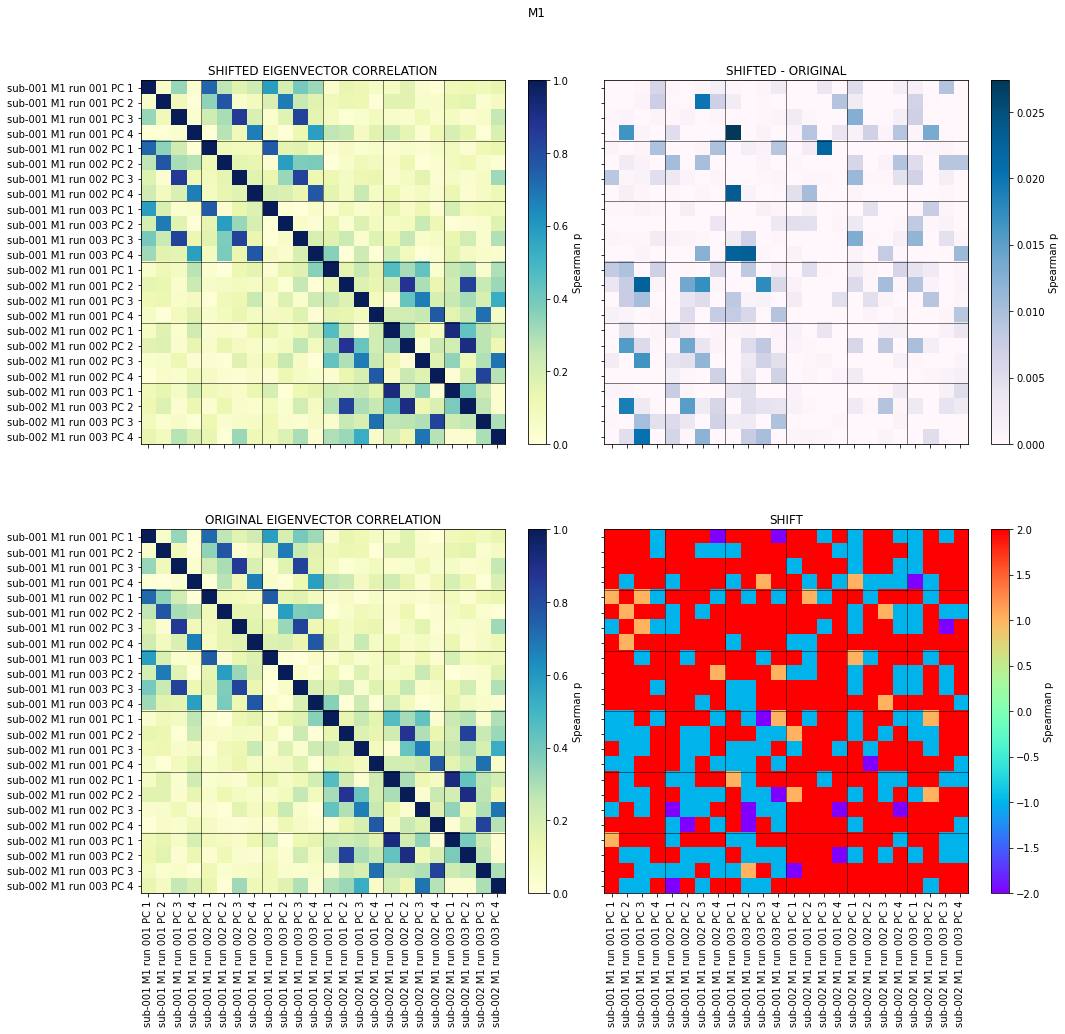

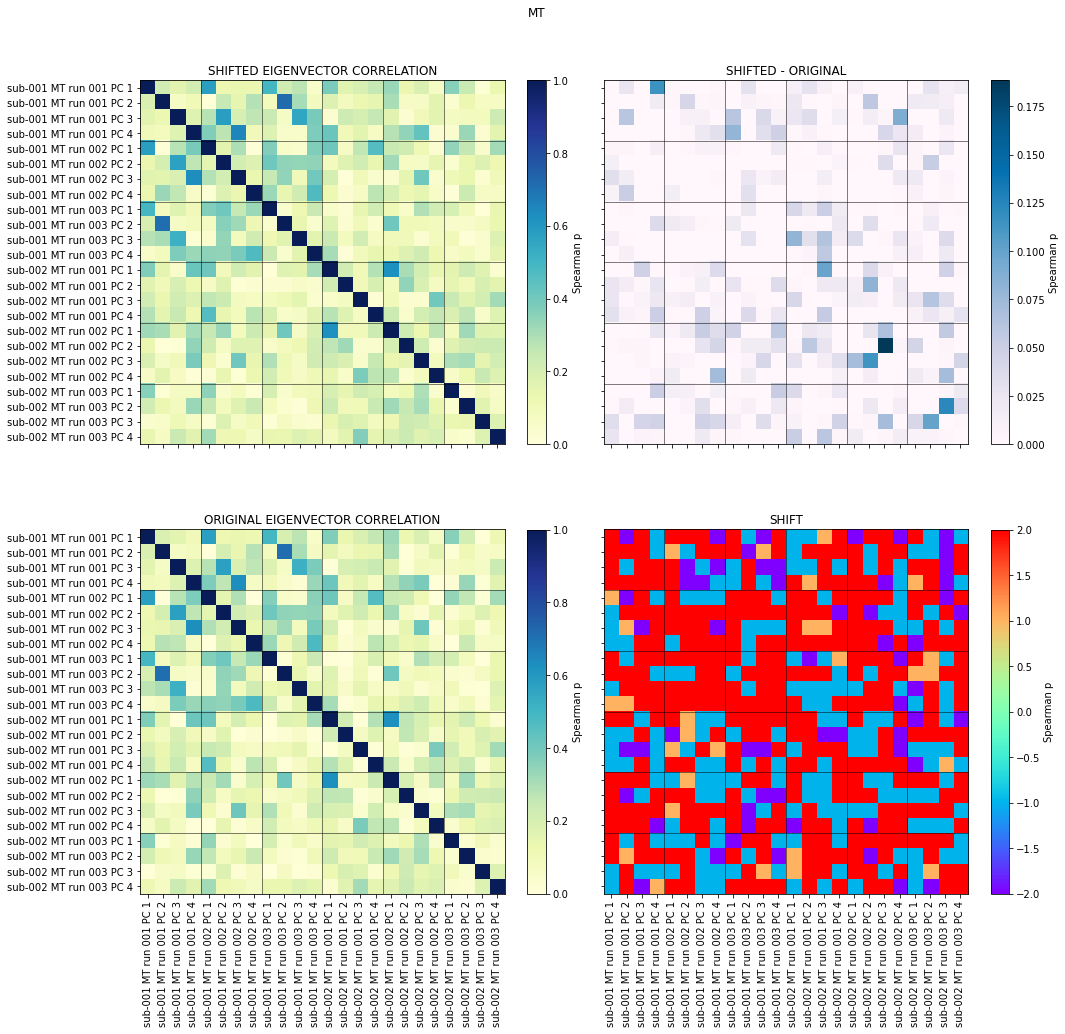

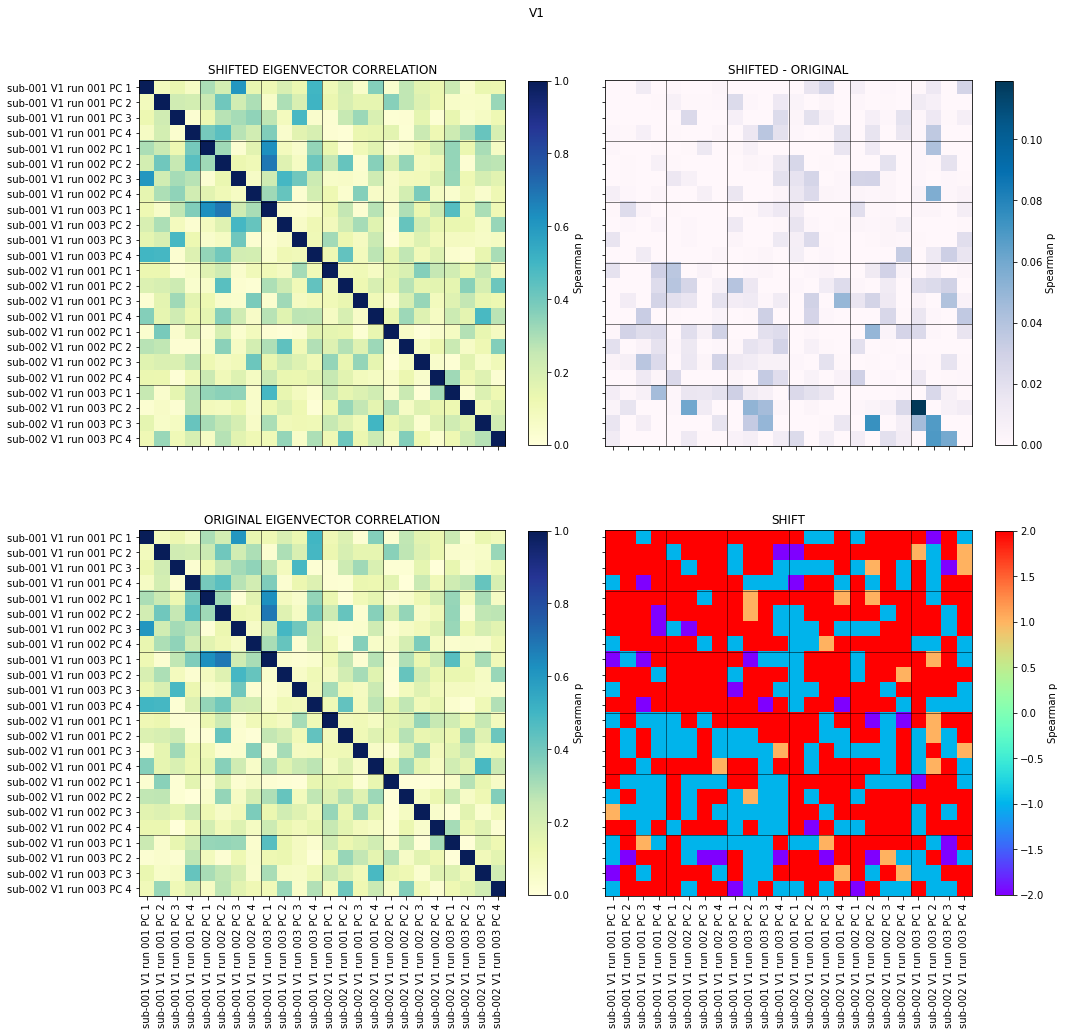

In [453]:
for roi_s in corr_data.roi.unique().tolist():
    key_s = corr_data.loc[corr_data.roi == roi_s].epoch_type.unique().tolist()[0]

    x = corr_data_split[key_s].loc[(corr_data_split[key_s].roi == roi_s)]
    y = corr_data_split[key_s].loc[(corr_data_split[key_s].roi == roi_s)]


    f, ax = plt.subplots(2, 2, figsize=(15, 15), facecolor="white", sharey=True, sharex=True)
    ax = ax.flatten()
    c = 0
    divnorm = colors.Normalize(vmin=0, vmax=1)
    im = ax[c].imshow(np.abs(corr_shifted[key_s][x.index, :][:, y.index]), norm=divnorm, cmap="YlGnBu")
    ax[c].set_xticks(np.arange(x.shape[0]))
    ax[c].set_xticklabels(ax[c].get_xticks(), rotation=90)
    ax[c].set_xticklabels(x.res_label)
    ax[c].set_yticks(np.arange(y.shape[0]))
    ax[c].set_yticklabels(y.res_label)

    for i in np.arange(0, x.shape[0], 4)[1:]-0.5:
        ax[c].axhline(i, lw=0.5, c="black")
    for i in np.arange(0, y.shape[0], 4)[1:]-0.5:
        ax[c].axvline(i, lw=0.5, c="black")
    ax[c].set_title("SHIFTED EIGENVECTOR CORRELATION")
    plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");

    c = 2
    divnorm = colors.Normalize(vmin=0, vmax=1)
    im = ax[c].imshow(np.abs(corr_notshifted[key_s][x.index, :][:, y.index]), norm=divnorm, cmap="YlGnBu")
    ax[c].set_xticks(np.arange(x.shape[0]))
    ax[c].set_xticklabels(ax[c].get_xticks(), rotation=90)
    ax[c].set_xticklabels(x.res_label)
    ax[c].set_yticks(np.arange(y.shape[0]))
    ax[c].set_yticklabels(y.res_label)

    for i in np.arange(0, x.shape[0], 4)[1:]-0.5:
        ax[c].axhline(i, lw=0.5, c="black")
    for i in np.arange(0, y.shape[0], 4)[1:]-0.5:
        ax[c].axvline(i, lw=0.5, c="black")
    ax[c].set_title("ORIGINAL EIGENVECTOR CORRELATION")
    plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");


    c = 1
    resu = np.abs(corr_shifted[key_s][x.index, :][:, y.index]) - np.abs(corr_notshifted[key_s][x.index, :][:, y.index])
    divnorm = colors.Normalize(vmin=0, vmax=np.max(resu))
    im = ax[c].imshow(resu, norm=divnorm, cmap="PuBu")
    ax[c].set_xticks(np.arange(x.shape[0]))
    ax[c].set_xticklabels(ax[c].get_xticks(), rotation=90)
    ax[c].set_xticklabels(x.res_label)
    ax[c].set_yticks(np.arange(y.shape[0]))
    ax[c].set_yticklabels(y.res_label)

    for i in np.arange(0, x.shape[0], 4)[1:]-0.5:
        ax[c].axhline(i, lw=0.5, c="black")
    for i in np.arange(0, y.shape[0], 4)[1:]-0.5:
        ax[c].axvline(i, lw=0.5, c="black")
    ax[c].set_title("SHIFTED - ORIGINAL")
    plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");

    c = 3
    divnorm = colors.TwoSlopeNorm(0, vmin=-2, vmax=2)
    im = ax[c].imshow(shift[key_s][x.index, :][:, y.index], norm=divnorm, cmap="rainbow")
    ax[c].set_xticks(np.arange(x.shape[0]))
    ax[c].set_xticklabels(ax[c].get_xticks(), rotation=90)
    ax[c].set_xticklabels(x.res_label)
    ax[c].set_yticks(np.arange(y.shape[0]))
    ax[c].set_yticklabels(y.res_label)

    for i in np.arange(0, x.shape[0], 4)[1:]-0.5:
        ax[c].axhline(i, lw=0.5, c="black")
    for i in np.arange(0, y.shape[0], 4)[1:]-0.5:
        ax[c].axvline(i, lw=0.5, c="black")
    ax[c].set_title("SHIFT")
    plt.colorbar(im, ax=ax[c], shrink=0.75, label="Spearman p");
    plt.suptitle(roi_s)
    plt.tight_layout()

1 [[ 49 -12]]
unaligned SpearmanrResult(correlation=0.016631917441112837, pvalue=8.321976305493904e-09)


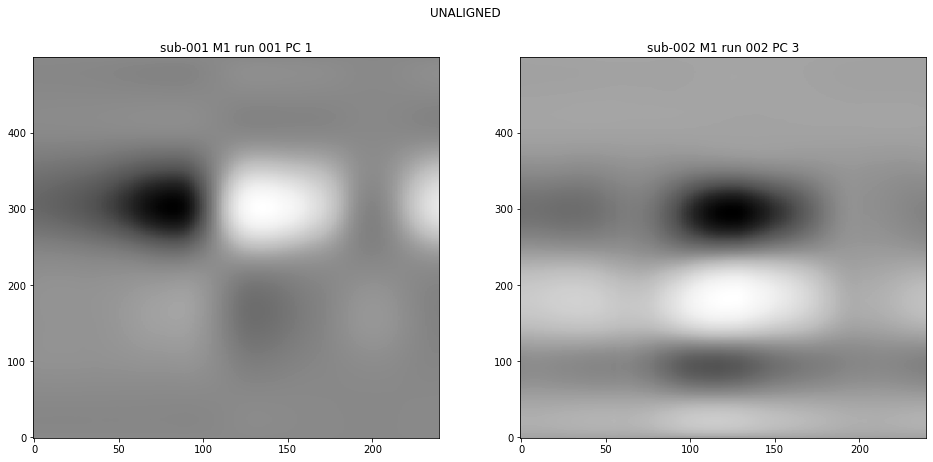

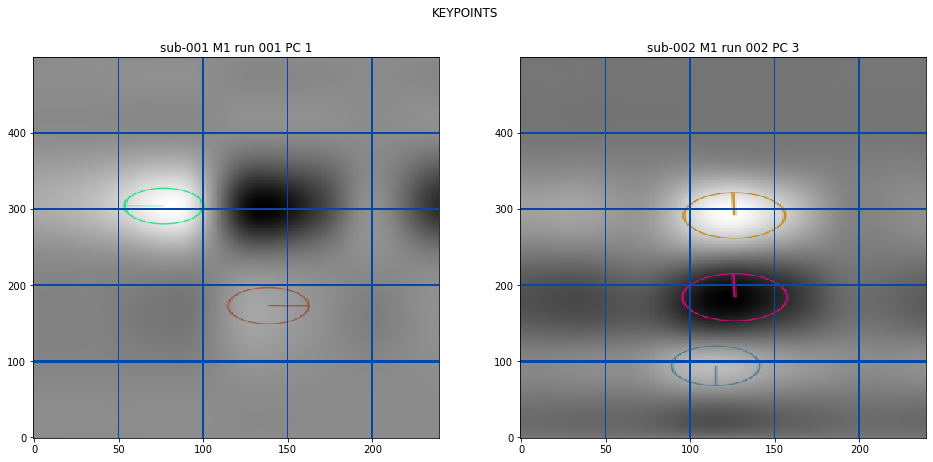

In [507]:
_, _, _, key1, _, pc1, lab1 = corr_data.loc[corr_data.res_label == "sub-001 M1 run 001 PC 1"].values.flatten()
_, _, _, key2, _, pc2, lab2 = corr_data.loc[corr_data.res_label == "sub-002 M1 run 002 PC 3"].values.flatten()
pc1 = pc1 - 1
pc2 = pc2 - 1

rimg1 = np.array(np.split(TOTAL_RESULTS[key1]["pca_results"][1][pc1], 11))
rimg2 = np.array(np.split(TOTAL_RESULTS[key2]["pca_results"][1][pc2], 11))
simg1 = norm_to_grayscale(smooth_csd(rimg1, 11))
simg2 = norm_to_grayscale(smooth_csd(rimg2, 11))
f, ax = plt.subplots(1, 2, figsize=(16,7), facecolor="white")
ax[0].imshow(simg1, origin="lower", aspect="auto", cmap="Greys", interpolation="none")
ax[0].set_title(lab1)
ax[1].imshow(simg2, origin="lower", aspect="auto", cmap="Greys", interpolation="none")
ax[1].set_title(lab2)
f.suptitle("UNALIGNED");
sift = cv2.SIFT_create()
skp1, sds1 = sift.detectAndCompute(simg1,None)
skeypoint1 = cv2.drawKeypoints(simg1, skp1, outImage=simg1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
skp2, sds2 = sift.detectAndCompute(simg2, None)
skeypoint2 = cv2.drawKeypoints(simg2, skp2, outImage=simg2, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

am_l_y = simg1.shape[0] // 100
am_l_x = simg1.shape[1] // 50
l_y1 = [(0, 100+100*i) for i in range(am_l_y)]
l_y2 = [(simg1.shape[0], 100+100*i) for i in range(am_l_y)]
l_x1 = [(50+50*i, 0) for i in range(am_l_y)]
l_x2 = [(50+50*i, simg1.shape[0]) for i in range(am_l_y)]
for i in range(am_l_y):
    cv2.line(skeypoint1, l_y1[i], l_y2[i], (0, 71, 171), thickness=2)
    cv2.line(skeypoint2, l_y1[i], l_y2[i], (0, 71, 171), thickness=2)
    cv2.line(skeypoint1, l_x1[i], l_x2[i], (0, 71, 171), thickness=1)
    cv2.line(skeypoint2, l_x1[i], l_x2[i], (0, 71, 171), thickness=1)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(sds1,sds2)

points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    for i, match in enumerate(matches):
        points1[i, :] = skp1[match.queryIdx].pt
        points2[i, :] = skp2[match.trainIdx].pt

dt = (points2 - points1).astype(int)
print(len(matches), dt)

f, ax = plt.subplots(1, 2, figsize=(16,7), facecolor="white")
ax[0].imshow(skeypoint1[:,:], origin="lower", aspect="auto", interpolation="none")
ax[0].set_title(lab1)
ax[1].imshow(skeypoint2[:,:], origin="lower", aspect="auto", interpolation="none")
ax[1].set_title(lab2)
f.suptitle("KEYPOINTS");

# f, ax = plt.subplots(1, 2, figsize=(16,7), facecolor="white")
# ax[0].imshow(simg1[:, 9:], origin="lower", aspect="auto", cmap="Greys", interpolation="none")
# ax[0].set_title("IMG1")
# ax[1].imshow(simg2[:, :-9], origin="lower", aspect="auto", cmap="Greys", interpolation="none")
# ax[1].set_title("IMG2")
# f.suptitle("ALIGNED")

print("unaligned", spearmanr(simg1.flatten(), simg2.flatten()))
# print("aligned", spearmanr(simg1[2:, :].flatten(), simg2[:-2, :].flatten()))

In [234]:
def norm_to_grayscale(arr):
    norm_arr = (arr - arr.min()) * 255 / (arr.max() - arr.min())
    norm_arr = norm_arr.astype(np.uint8)
    nans, x, = nan_helper(norm_arr)
    norm_arr[nans]= np.interp(x(nans), x(~nans), norm_arr[~nans])
    return norm_arr

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]